In [1]:
# Standard library imports
import re
import pickle

# Third-party imports for data manipulation
import numpy as np
import pandas as pd

# Imports for natural language processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

# Imports for data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Imports for word embeddings
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Imports for building neural network models
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, LSTM, Dropout, Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, Flatten
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

# Imports for model evaluation
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [2]:
# Load the dataset
df = pd.read_csv('movie.csv', engine='python')

[Text(0, 0, 'Negative'), Text(1, 0, 'Positive')]

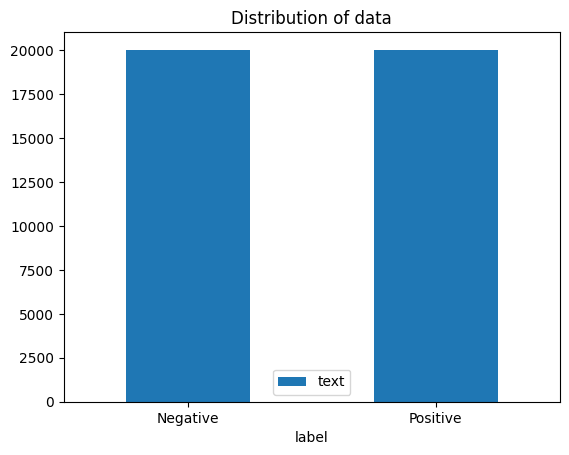

In [3]:
# Group data by 'label' and count the number of occurrences
data_distribution = df.groupby('label').count()

# Create bar plot of the data distribution
bar_plot = data_distribution.plot(kind='bar', title='Distribution of data')

# Set x-axis labels
labels = ['Negative','Positive']
bar_plot.set_xticklabels(labels, rotation=0)

## Data **Preprocessing**

In [4]:
# Load contractions
contraction_data = pd.read_csv('contractions.csv', index_col='Contraction')
contraction_data.index = contraction_data.index.str.lower()
contraction_data.Meaning = contraction_data.Meaning.str.lower()
contraction_dict = contraction_data.to_dict()['Meaning']

# Define patterns
line_breaks_pattern = "<br /><br />"
non_alphanumeric_pattern = "[^a-z0-9<>]"
repeated_chars_pattern = r"(.)\1\1+"
repeated_chars_replace_pattern = r"\1\1"
smile_emoji_pattern = r"[8:=;]['`\-]?[)d]+"
sad_emoji_pattern = r"[8:=;]['`\-]?\(+"
neutral_emoji_pattern = r"[8:=;]['`\-]?[\/|l*]"
lol_emoji_pattern = r"[8:=;]['`\-]?p+"
surprise_emoji_pattern = r"[8:=;]['`\-]?[oO]"
wink_emoji_pattern = r"[;]['`\-]?[)]"
hashtag_pattern = r"#(\w+)"



def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Replace line breaks
    text = re.sub(line_breaks_pattern, " ", text)

    # Replace 3 or more consecutive letters by 2 letters
    text = re.sub(repeated_chars_pattern, repeated_chars_replace_pattern, text)

    # Replace emojis
    text = re.sub(r'<3', '<heart>', text)
    text = re.sub(smile_emoji_pattern, '<smile>', text)
    text = re.sub(sad_emoji_pattern, '<sadface>', text)
    text = re.sub(neutral_emoji_pattern, '<neutralface>', text)
    text = re.sub(lol_emoji_pattern, '<lolface>', text)
    text = re.sub(surprise_emoji_pattern, '<surpriseface>', text)
    text = re.sub(wink_emoji_pattern, '<winkface>', text)

    # Replace hashtag
    text = re.sub(hashtag_pattern, '<hashtag> \1', text)

    # Replace contractions
    for contraction, replacement in contraction_dict.items():
        text = text.replace(contraction, replacement)

    # Remove non-alphanumeric characters
    text = re.sub(non_alphanumeric_pattern, ' ', text)

    # Replace forward slashes with spaces
    text = re.sub(r'/', ' / ', text)

    # Additional preprocessing steps
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

df['cleaned_review'] = df.text.apply(preprocess_text)

In [5]:
# Set up stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Apply preprocessing to each review
for i in range(len(df)):
    word_list = []
    for word in df["cleaned_review"][i].split():
        # Remove stop words
        if word not in stop_words:
            # Apply lemmatization
            word = lemmatizer.lemmatize(word)
            word_list.append(word)
    # Join the words back into a single string
    df["cleaned_review"][i] = " ".join(word_list)

<ipython-input-5-d0a875dcf07b>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["cleaned_review"][i] = " ".join(word_list)


In [6]:
X = df['cleaned_review']
y = df['label']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
# Set parameters
Embedding_dimensions = 100
input_length = 500
vocab_length = 35000

# Create Word2Vec training dataset and train Word2Vec model
Word2vec_train_data = list(map(lambda x: x.split(), X_train))
word2vec_model = Word2Vec(Word2vec_train_data, vector_size=Embedding_dimensions, workers=8, min_count=5)

# Initialize tokenizer and fit on texts
tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(X_train)
tokenizer.num_words = vocab_length

# Convert texts to sequences and pad sequences
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=input_length)
X_test  = pad_sequences(tokenizer.texts_to_sequences(X_test) , maxlen=input_length)

# Create embedding matrix
embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))
for word, token in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

## **Model Implementation**

### **RNN**

In [8]:
# Define the embedding layer
embedding_layer = Embedding(input_dim=vocab_length,
                            output_dim=Embedding_dimensions,
                            weights=[embedding_matrix],
                            input_length=input_length,
                            trainable=False)

# Define the RNN model
rnn_model = Sequential([
    embedding_layer,
    SimpleRNN(100, return_sequences=False, activation="relu"),
    Dense(32, activation="relu"),
    Dense(1, activation="sigmoid"),
])

# Compile the model
rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)

# Train the model
history = rnn_model.fit(
    X_train, y_train,
    batch_size=1024,
    epochs=10,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1,
)

Epoch 1/10
29/29 [==============================] - 71s 2s/step - loss: 0.6899 - accuracy: 0.5842 - val_loss: 0.6237 - val_accuracy: 0.6528
Epoch 2/10
29/29 [==============================] - 69s 2s/step - loss: 0.5810 - accuracy: 0.6881 - val_loss: 0.5027 - val_accuracy: 0.7616
Epoch 3/10
29/29 [==============================] - 67s 2s/step - loss: 0.4399 - accuracy: 0.7987 - val_loss: 0.4047 - val_accuracy: 0.8250
Epoch 4/10
29/29 [==============================] - 68s 2s/step - loss: 0.4826 - accuracy: 0.7766 - val_loss: 0.4372 - val_accuracy: 0.7966
Epoch 5/10
29/29 [==============================] - 68s 2s/step - loss: 0.4066 - accuracy: 0.8196 - val_loss: 0.4089 - val_accuracy: 0.8206
Epoch 6/10
29/29 [==============================] - 73s 3s/step - loss: 0.3800 - accuracy: 0.8341 - val_loss: 0.3810 - val_accuracy: 0.8444
Epoch 7/10
29/29 [==============================] - 71s 2s/step - loss: 0.3606 - accuracy: 0.8466 - val_loss: 0.3669 - val_accuracy: 0.8447
Epoch 8/10
29/29 [==

In [9]:
# Make predictions on the test data
y_pred_rnn = rnn_model.predict(X_test)
y_pred_rnn = np.round(y_pred_rnn)  # Round to get 0 or 1 because we're dealing with binary classification

# Calculate accuracy
accuracy_rnn = accuracy_score(y_test, y_pred_rnn) * 100
print(f"RNN Model Accuracy: {accuracy_rnn:.2f}%")

# Calculate F1 score
f1_rnn = f1_score(y_test, y_pred_rnn, average='binary') * 100
print(f"RNN Model F1 Score: {f1_rnn:.2f}%")

250/250 [==============================] - 14s 54ms/step
RNN Model Accuracy: 84.80%
RNN Model F1 Score: 85.78%


### **CNN**

In [10]:
# Define the embedding layer
embedding_layer = Embedding(input_dim=vocab_length,
                            output_dim=Embedding_dimensions,
                            weights=[embedding_matrix],
                            input_length=input_length,
                            trainable=False)

# Define the CNN model
cnn_model = Sequential([
    embedding_layer,
    Conv1D(100, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid'),
])

# Compile the model
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)

# Train the model
history = cnn_model.fit(
    X_train, y_train,
    batch_size=1024,
    epochs=10,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1,
)

Epoch 1/10
29/29 [==============================] - 108s 4s/step - loss: 0.5226 - accuracy: 0.7339 - val_loss: 0.4201 - val_accuracy: 0.8112
Epoch 2/10
29/29 [==============================] - 108s 4s/step - loss: 0.3674 - accuracy: 0.8395 - val_loss: 0.3645 - val_accuracy: 0.8428
Epoch 3/10
29/29 [==============================] - 114s 4s/step - loss: 0.3178 - accuracy: 0.8663 - val_loss: 0.3533 - val_accuracy: 0.8497
Epoch 4/10
29/29 [==============================] - 109s 4s/step - loss: 0.2884 - accuracy: 0.8821 - val_loss: 0.3450 - val_accuracy: 0.8562
Epoch 5/10
29/29 [==============================] - 104s 4s/step - loss: 0.2648 - accuracy: 0.8925 - val_loss: 0.3356 - val_accuracy: 0.8559
Epoch 6/10
29/29 [==============================] - 104s 4s/step - loss: 0.2439 - accuracy: 0.9031 - val_loss: 0.3335 - val_accuracy: 0.8603
Epoch 7/10
29/29 [==============================] - 105s 4s/step - loss: 0.2249 - accuracy: 0.9111 - val_loss: 0.3285 - val_accuracy: 0.8594
Epoch 8/10
29

In [11]:
# Make predictions on the test data
y_pred_cnn = cnn_model.predict(X_test)
y_pred_cnn = np.round(y_pred_cnn)  # Round to get 0 or 1 because we're dealing with binary classification

# Calculate accuracy
accuracy_cnn = accuracy_score(y_test, y_pred_cnn) * 100
print(f"CNN Model Accuracy: {accuracy_cnn:.2f}%")

# Calculate F1 score
f1_cnn = f1_score(y_test, y_pred_cnn, average='binary') * 100
print(f"CNN Model F1 Score: {f1_cnn:.2f}%")

250/250 [==============================] - 11s 45ms/step
CNN Model Accuracy: 86.01%
CNN Model F1 Score: 86.58%


## **Conclusion**

## Confusion Matrix

Confusion Matrix for RNN Model:
 [[3116  850]
 [ 366 3668]]
Confusion Matrix for CNN Model:
 [[3270  696]
 [ 423 3611]]


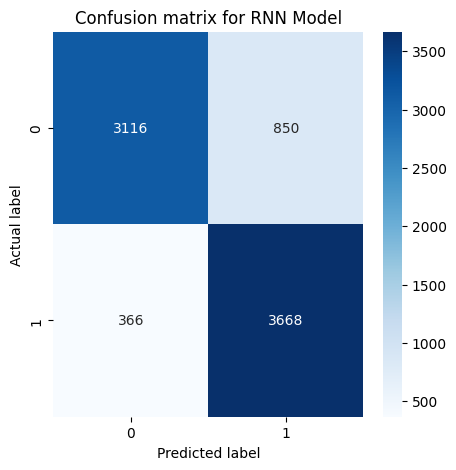

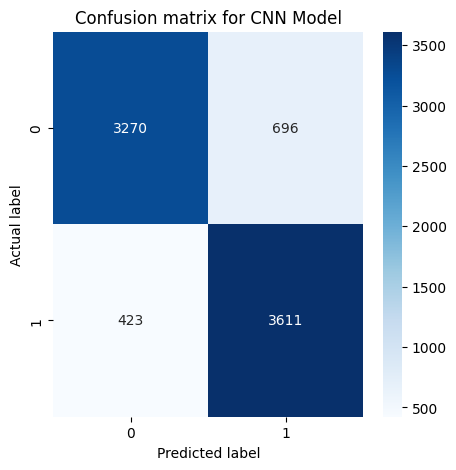

In [15]:
# Confusion matrix for RNN model
cm_rnn = confusion_matrix(y_test, y_pred_rnn)
plt.figure(figsize=(5, 5))
sns.heatmap(cm_rnn, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion matrix for RNN Model')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
print("Confusion Matrix for RNN Model:\n", cm_rnn)

# Confusion matrix for CNN model
cm_cnn = confusion_matrix(y_test, y_pred_cnn)
plt.figure(figsize=(5, 5))
sns.heatmap(cm_cnn, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion matrix for CNN Model')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
print("Confusion Matrix for CNN Model:\n", cm_cnn)

## Classification Report

In [13]:
# Classification report for RNN model
report_rnn = classification_report(y_test, y_pred_rnn, target_names=['Negative', 'Positive'])
print("Classification Report for RNN Model:\n", report_rnn)

# Classification report for CNN model
report_cnn = classification_report(y_test, y_pred_cnn, target_names=['Negative', 'Positive'])
print("Classification Report for CNN Model:\n", report_cnn)


Classification Report for RNN Model:
               precision    recall  f1-score   support

    Negative       0.89      0.79      0.84      3966
    Positive       0.81      0.91      0.86      4034

    accuracy                           0.85      8000
   macro avg       0.85      0.85      0.85      8000
weighted avg       0.85      0.85      0.85      8000

Classification Report for CNN Model:
               precision    recall  f1-score   support

    Negative       0.89      0.82      0.85      3966
    Positive       0.84      0.90      0.87      4034

    accuracy                           0.86      8000
   macro avg       0.86      0.86      0.86      8000
weighted avg       0.86      0.86      0.86      8000

Classification Report for RNN Model:
               precision    recall  f1-score   support

    Negative       0.89      0.79      0.84      3966
    Positive       0.81      0.91      0.86      4034

    accuracy                           0.85      8000
   macro avg  